# Advanced Fraud Modeling in Python

This notebook covers the material in the advanced fraud modeling piece of the course. It goes through three main modules as follows:

1. Data Preparation
2. Supervised Modeling
3. Implementation Deployment

The following code loads all the necessary packages and libraries for the analysis.

In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import lime
import lime.lime_tabular

## Data Preparation

This module details the area of data preparation for good Fraud detection. Fraud detection is only as good as the data and the features that you have to detect anomalies and possible fraud in your data. This module covers four main concepts in data preparation:

1. Feature Engineering
2. Fraud Data
3. Sampling Concerns

Let's load the dataset we will be working with.

In [8]:
ins = pd.read_csv("transactions_ins.csv")

ins.head()

,Date,Cust_ID,Transaction,Type,Reward_R,Reward_A,Cov_Limit,Income
0,9/10/1977,PSX000100006,IN,T,NaN,NaN,50000.0,61000.0
1,12/31/2005,PSX000100006,CL,T,NaN,NaN,50000.0,61000.0
2,1/17/2006,PSX000100006,RE,T,265.0,50000.0,NaN,NaN
3,12/15/1998,PSX000100010,IN,T,NaN,NaN,100000.0,29000.0
4,6/7/1961,PSX000100013,IN,V,NaN,NaN,100000.0,48000.0


In [9]:
ins.describe(include='all')

,Date,Cust_ID,Transaction,Type,Reward_R,Reward_A,Cov_Limit,Income
count,278877,278877,278877,278877,44488.000000,4.448800e+04,2.343890e+05,234389.000000
unique,23165,121191,4,3,NaN,NaN,NaN,NaN
top,9/15/2010,PSX000704539,IN,T,NaN,NaN,NaN,NaN
freq,44,21,121191,139958,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,315.732602,2.247246e+05,2.057786e+05,53363.899594
std,NaN,NaN,NaN,NaN,126.895957,2.284420e+05,1.984034e+05,25199.547677
min,NaN,NaN,NaN,NaN,100.000000,0.000000e+00,5.000000e+04,15000.000000
25%,NaN,NaN,NaN,NaN,207.000000,1.000000e+05,1.000000e+05,34422.000000
50%,NaN,NaN,NaN,NaN,314.000000,1.500000e+05,1.500000e+05,50000.000000
75%,NaN,NaN,NaN,NaN,421.000000,3.000000e+05,2.500000e+05,68026.000000


In [10]:
ins['Date'] = pd.to_datetime(ins['Date'])

### Feature Engineering

The concept of feature engineering is vitally important to fraud detection. In my personal experience, the best features aren't just automatically generated by a computer, but thought up by a knowledgable individual working on the problem. 

We are going to role up the transactions to be one per individual. Here are some basic features when rolling up our transactions that might be important when discovering fraud:
- Final income
- Time between claim and reward
- Coverage limit to income ratio at claim

Think of some more of your own!

Let's create final income.

In [11]:
ins_income = ins[ins['Transaction'] == 'CL']

ins_income = ins_income[['Cust_ID', 'Cov_Limit', 'Income']]

ins_income.head(n = 10)

,Cust_ID,Cov_Limit,Income
1,PSX000100006,50000.0,61000.0
5,PSX000100013,100000.0,48000.0
14,PSX000100073,100000.0,35000.0
18,PSX000100081,50000.0,69000.0
24,PSX000100122,150000.0,105000.0
31,PSX000100146,100000.0,38000.0
50,PSX000100231,400000.0,79155.0
56,PSX000100236,250000.0,54738.0
62,PSX000100286,150000.0,95973.0
67,PSX00010030,350000.0,37725.0


Now, let's create time in between claim and reward.

In [12]:
ins_time = ins[(ins['Transaction'] == 'CL') | (ins['Transaction'] == 'RE')]

ins_time.head(n = 10)

,Date,Cust_ID,Transaction,Type,Reward_R,Reward_A,Cov_Limit,Income
1,2005-12-31,PSX000100006,CL,T,NaN,NaN,50000.0,61000.0
2,2006-01-17,PSX000100006,RE,T,265.0,50000.0,NaN,NaN
5,2001-06-12,PSX000100013,CL,V,NaN,NaN,100000.0,48000.0
6,2001-07-11,PSX000100013,RE,V,265.0,100000.0,NaN,NaN
14,2004-01-21,PSX000100073,CL,V,NaN,NaN,100000.0,35000.0
15,2004-02-14,PSX000100073,RE,V,450.0,100000.0,NaN,NaN
18,2009-06-28,PSX000100081,CL,T,NaN,NaN,50000.0,69000.0
19,2009-07-26,PSX000100081,RE,T,543.0,0.0,NaN,NaN
24,1991-08-23,PSX000100122,CL,T,NaN,NaN,150000.0,105000.0
25,1991-09-08,PSX000100122,RE,T,200.0,150000.0,NaN,NaN


In [13]:
ins_time['diff'] = ins_time['Date'] - ins_time['Date'].shift(1)

ins_time.head(n = 10)

C:\Users\Aric\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,Cust_ID,Transaction,Type,Reward_R,Reward_A,Cov_Limit,Income,diff
1,2005-12-31,PSX000100006,CL,T,NaN,NaN,50000.0,61000.0,NaT
2,2006-01-17,PSX000100006,RE,T,265.0,50000.0,NaN,NaN,17 days
5,2001-06-12,PSX000100013,CL,V,NaN,NaN,100000.0,48000.0,-1680 days
6,2001-07-11,PSX000100013,RE,V,265.0,100000.0,NaN,NaN,29 days
14,2004-01-21,PSX000100073,CL,V,NaN,NaN,100000.0,35000.0,924 days
15,2004-02-14,PSX000100073,RE,V,450.0,100000.0,NaN,NaN,24 days
18,2009-06-28,PSX000100081,CL,T,NaN,NaN,50000.0,69000.0,1961 days
19,2009-07-26,PSX000100081,RE,T,543.0,0.0,NaN,NaN,28 days
24,1991-08-23,PSX000100122,CL,T,NaN,NaN,150000.0,105000.0,-6547 days
25,1991-09-08,PSX000100122,RE,T,200.0,150000.0,NaN,NaN,16 days


In [14]:
ins_time = ins_time[ins_time['Transaction'] == 'RE']

ins_time = ins_time[['Date', 'Cust_ID', 'Type', 'Reward_R', 'Reward_A', 'diff']]

ins_time.head(n = 10)

,Date,Cust_ID,Type,Reward_R,Reward_A,diff
2,2006-01-17,PSX000100006,T,265.0,50000.0,17 days
6,2001-07-11,PSX000100013,V,265.0,100000.0,29 days
15,2004-02-14,PSX000100073,V,450.0,100000.0,24 days
19,2009-07-26,PSX000100081,T,543.0,0.0,28 days
25,1991-09-08,PSX000100122,T,200.0,150000.0,16 days
32,2009-04-21,PSX000100146,T,275.0,100000.0,20 days
51,2008-05-05,PSX000100231,V,405.0,400000.0,25 days
57,1970-10-06,PSX000100236,T,469.0,250000.0,24 days
63,2003-03-20,PSX000100286,V,337.0,150000.0,22 days
68,1980-01-09,PSX00010030,T,377.0,350000.0,23 days


Lastly, let's combine our datasets from above and create coverage limit to income ratio.

In [15]:
ins_feat = ins_time.merge(ins_income)

ins_feat.head(n = 10)

,Date,Cust_ID,Type,Reward_R,Reward_A,diff,Cov_Limit,Income
0,2006-01-17,PSX000100006,T,265.0,50000.0,17 days,50000.0,61000.0
1,2001-07-11,PSX000100013,V,265.0,100000.0,29 days,100000.0,48000.0
2,2004-02-14,PSX000100073,V,450.0,100000.0,24 days,100000.0,35000.0
3,2009-07-26,PSX000100081,T,543.0,0.0,28 days,50000.0,69000.0
4,1991-09-08,PSX000100122,T,200.0,150000.0,16 days,150000.0,105000.0
5,2009-04-21,PSX000100146,T,275.0,100000.0,20 days,100000.0,38000.0
6,2008-05-05,PSX000100231,V,405.0,400000.0,25 days,400000.0,79155.0
7,1970-10-06,PSX000100236,T,469.0,250000.0,24 days,250000.0,54738.0
8,2003-03-20,PSX000100286,V,337.0,150000.0,22 days,150000.0,95973.0
9,1980-01-09,PSX00010030,T,377.0,350000.0,23 days,350000.0,37725.0


In [16]:
ins_feat['Cov_Income_Ratio'] = ins_feat['Cov_Limit'] / ins_feat['Income']

ins_feat.head(n = 10)

,Date,Cust_ID,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio
0,2006-01-17,PSX000100006,T,265.0,50000.0,17 days,50000.0,61000.0,0.819672
1,2001-07-11,PSX000100013,V,265.0,100000.0,29 days,100000.0,48000.0,2.083333
2,2004-02-14,PSX000100073,V,450.0,100000.0,24 days,100000.0,35000.0,2.857143
3,2009-07-26,PSX000100081,T,543.0,0.0,28 days,50000.0,69000.0,0.724638
4,1991-09-08,PSX000100122,T,200.0,150000.0,16 days,150000.0,105000.0,1.428571
5,2009-04-21,PSX000100146,T,275.0,100000.0,20 days,100000.0,38000.0,2.631579
6,2008-05-05,PSX000100231,V,405.0,400000.0,25 days,400000.0,79155.0,5.053376
7,1970-10-06,PSX000100236,T,469.0,250000.0,24 days,250000.0,54738.0,4.567211
8,2003-03-20,PSX000100286,V,337.0,150000.0,22 days,150000.0,95973.0,1.562940
9,1980-01-09,PSX00010030,T,377.0,350000.0,23 days,350000.0,37725.0,9.277667


### Fraud Data

One of the possible ways of creating flags for suspicious cases without any previously recorded cases is to use anomaly detection methods. There is an entire AI+ training course on anomaly detection algorithms to learn these in much more detail. Let's investigate one of them here - one-class support vector machines (SVM's).

The main idea behind an SVM is that it is a density based approach that creates hyperplanes to "best" separate your data in a multi-dimensional space. Let's take an example of comparing income to the coverage income ratio.

Text(0.5, 1.0, 'Income vs. Coverage to Income Ratio')

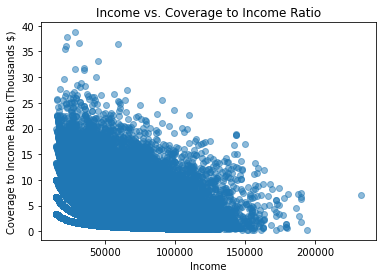

In [17]:
plt.scatter(x = ins_feat['Income'], y = ins_feat['Cov_Income_Ratio'], alpha = 0.5)
plt.xlabel('Income')
plt.ylabel('Coverage to Income Ratio (Thousands $)')
plt.title('Income vs. Coverage to Income Ratio')

Now let's build a one-class SVM trying to identify 3% of the most anomalous observations.

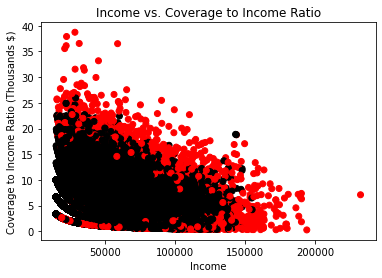

In [18]:
d = {'Income': ins_feat['Income'], 'CIRatio': ins_feat['Cov_Income_Ratio']}
df = pd.DataFrame(data=d)

svm = OneClassSVM(gamma=0.000005, nu = 0.03).fit_predict(df)

df['svm'] = svm

fig, ax = plt.subplots()

colors = {-1:'red', 1:'black'}

ax.scatter(ins_feat['Income'], ins_feat['Cov_Income_Ratio'], c = df['svm'].map(colors))
plt.xlabel('Income')
plt.ylabel('Coverage to Income Ratio (Thousands $)')
plt.title('Income vs. Coverage to Income Ratio')
plt.show()

From here we would pass these observations to an SME to flag for potential fraud or not fraud. 

In [19]:
df['fraud_flag'] = df['svm'] < 0

df['fraud_flag'] = df['fraud_flag'].astype("int")

df.head()

,Income,CIRatio,svm,fraud_flag
0,61000.0,0.819672,1,0
1,48000.0,2.083333,1,0
2,35000.0,2.857143,1,0
3,69000.0,0.724638,1,0
4,105000.0,1.428571,1,0


Let's assume we have done this a few times with a few other variables to achieve a "fraud flag" variable in our dataset.

In [20]:
ins_label = pd.read_csv("ins_label.csv")

ins_label.head(n = 10)

,Cust_ID,Date,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio,fraud_flag
0,PSX000100006,1/17/2006,T,265,50000,17,50000,61000,0.819672,0
1,PSX000100013,7/11/2001,V,265,100000,29,100000,48000,2.083333,0
2,PSX000100073,2/14/2004,V,450,100000,24,100000,35000,2.857143,0
3,PSX000100081,7/26/2009,T,543,0,28,50000,69000,0.724638,0
4,PSX000100122,9/8/1991,T,200,150000,16,150000,105000,1.428571,0
5,PSX000100146,4/21/2009,T,275,100000,20,100000,38000,2.631579,0
6,PSX000100231,5/5/2008,V,405,400000,25,400000,79155,5.053376,0
7,PSX000100236,10/6/1970,T,469,250000,24,250000,54738,4.567211,0
8,PSX000100286,3/20/2003,V,337,150000,22,150000,95973,1.562940,0
9,PSX00010030,1/9/1980,T,377,350000,23,350000,37725,9.277667,0


### Sampling Concerns

When we have a rare event, the modeling may be impacted. It is easy to predict everything isn't fraud and be right a large portion of the time. However, that defeats the purpose of the model. Let's see how rare our fraud is.

In [21]:
pd.crosstab(index = ins_label['fraud_flag'], columns = "count") 

col_0,count
fraud_flag,
0,42872
1,1616


In [22]:
pd.crosstab(index = ins_label['fraud_flag'], columns = "prop")/pd.crosstab(index = ins_label['fraud_flag'], columns = "prop").sum()

col_0,prop
fraud_flag,
0,0.963676
1,0.036324


Looks like our suspected fraud instances are only 3.63% of the data. This is a rare event problem.

Now's lets sample 1200 suspected fraud and 1200 that are not suspected fraud to balance things out for modeling. This will be our training dataset.

In [23]:
train = ins_label.groupby("fraud_flag").sample(n = 1200, random_state=12345)

test = ins_label[~ins_label['Cust_ID'].isin(train['Cust_ID'])]

train.head()

,Cust_ID,Date,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio,fraud_flag
10408,PSX000308247,8/11/1999,V,306,150000,30,150000,25952,5.779901,0
16756,PSX000435754,8/10/1990,T,310,350000,27,350000,47318,7.396762,0
37292,PSX000854018,2/12/2011,T,105,100000,25,100000,38000,2.631579,0
25897,PSX000622557,6/3/2008,V,342,100000,15,100000,48000,2.083333,0
39843,PSX000906273,10/2/2002,T,263,100000,28,100000,20000,5.000000,0


In [24]:
pd.crosstab(index = train['fraud_flag'], columns = "count") 

col_0,count
fraud_flag,
0,1200
1,1200


In [25]:
pd.crosstab(index = test['fraud_flag'], columns = "count") 

col_0,count
fraud_flag,
0,41672
1,416


Now, we need to weight our observations. If our models do a good job at predicting this training set, it might not be as good as we think. This is due to the training set not looking like our population. When building models, we can weight our observations so that the predictions coming from the model are adjusted back to the original population proportion of our target.

In [26]:
p_0 = 0.5 
p_1 = 0.5
P_1 = ins_label['fraud_flag'].sum()/len(ins_label['fraud_flag'])
P_0 = 1 - P_1

train['weight'] = np.where(train['fraud_flag'] == 1, 1, (p_1*P_0)/(p_0*P_1))

pd.crosstab(train['fraud_flag'], train['weight']) 

weight,1.000000,26.529703
fraud_flag,,
0,0,1200
1,1200,0


If we wanted to get a little fancier for our adjustment to sampling, we could use SMOTE. The only problem with SMOTE is that we need to use only numerical variables and not categorical ones.

In [27]:
d = {'Income': ins_label['Income'], 'Cov_Limit': ins_label['Cov_Limit'], 'diff': ins_label['diff']}
df = pd.DataFrame(data=d)

train_s_X, train_s_y = SMOTE().fit_resample(df, ins_label['fraud_flag'])

train_s_X.head()

,Income,Cov_Limit,diff
0,61000,50000,17
1,48000,100000,29
2,35000,100000,24
3,69000,50000,28
4,105000,150000,16


In [28]:
st.describe(train_s_y)

DescribeResult(nobs=85744, minmax=(0, 1), mean=0.5, variance=0.25000291568991057, skewness=0.0, kurtosis=-2.0)

From here you would simply split your data into training and testing like we did above. SMOTE isn't the best example for our data because of a couple of restrictions:

1. We can't use categorical data. For us, reward reason and insurance policy may be important but we cannot use them in SMOTE.
2. Data restrictions. Our reward amount has to be the same as the coverage limit so we shouldn't randomly create reward amount. This is the same for our coverage to income ratio variable. It is restricted based on other variables. If we were to use SMOTE, we would need to go back after the fact and create these two variables from the transformations.

## Supervised Modeling

Supervised techniques have a known target they are trying to predict. Let's build a variety of supervised models trying to predict our target - suspected fraud.

### Interpretable Models

The first interpretable model we will build is a decision tree.

In [29]:
X = train.drop(columns=['Cust_ID', 'Date', 'fraud_flag', 'weight'])
y = train['fraud_flag']

X = pd.get_dummies(X)

X.head()

,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio,Type_T,Type_V,Type_W
10408,306,150000,30,150000,25952,5.779901,0,1,0
16756,310,350000,27,350000,47318,7.396762,1,0,0
37292,105,100000,25,100000,38000,2.631579,1,0,0
25897,342,100000,15,100000,48000,2.083333,0,1,0
39843,263,100000,28,100000,20000,5.000000,1,0,0


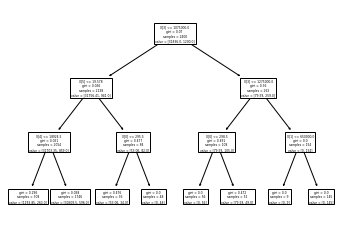

In [30]:
fit_dt = tree.DecisionTreeClassifier(max_depth = 3, class_weight = {0: 26.53, 1: 1}).fit(X, y)

tree.plot_tree(fit_dt)
plt.show()

In [31]:
train['pred_dt'] = fit_dt.predict_proba(X)[:,1]

train.head()

,Cust_ID,Date,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio,fraud_flag,weight,pred_dt
10408,PSX000308247,8/11/1999,V,306,150000,30,150000,25952,5.779901,0,26.529703,0.019161
16756,PSX000435754,8/10/1990,T,310,350000,27,350000,47318,7.396762,0,26.529703,0.019161
37292,PSX000854018,2/12/2011,T,105,100000,25,100000,38000,2.631579,0,26.529703,0.019161
25897,PSX000622557,6/3/2008,V,342,100000,15,100000,48000,2.083333,0,26.529703,0.019161
39843,PSX000906273,10/2/2002,T,263,100000,28,100000,20000,5.000000,0,26.529703,0.019161


The second interpretable model that we are going to build is a logistic regression model.

In [32]:
fit_lr = smf.glm('fraud_flag ~ C(Type) + Reward_R + Reward_A + Income + Cov_Limit + Cov_Income_Ratio + diff', 
                 data = train, family = sm.families.Binomial(), freq_weights=np.asarray(train['weight'])).fit()

fit_lr.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
=================================================================
Model:              GLM              AIC:            8514.2079   
Link Function:      logit            BIC:            -335157.3256
Dependent Variable: fraud_flag       Log-Likelihood: -4248.1     
Date:               2021-03-12 16:33 LL-Null:        -5156.3     
No. Observations:   2400             Deviance:       8496.2      
Df Model:           8                Pearson chi2:   5.79e+04    
Df Residuals:       33026            Scale:          1.0000      
Method:             IRLS                                         
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Intercept        -6.5623   0.2539 -25.8433 0.0000 -7.0600 -6.0646
C(Type)[T.V]     -0.0305   0.0728  -0.4189 0.6753 -0.1732  0.1122
C(Type)[T.W]     -0.3483   0.0844  -4.1252 0.0000 -0.5137 -0.1828
Reward_R         -0.0004   0.0003  -1.6460 0.0998 -0.0010  0.0001
Reward_A         -0.0000   0.0000  -0.6444 0.5193 -0.0000  0.0000
Income            0.0000   0.0000  12.9460 0.0000  0.0000  0.0000
Cov_Limit         0.0000   0.0000   3.4747 0.0005  0.0000  0.0000
Cov_Income_Ratio  0.1811   0.0122  14.8462 0.0000  0.1571  0.2050
diff              0.0288   0.0081   3.5534 0.0004  0.0129  0.0447
=================================================================

"""

In [33]:
fit_lr = smf.glm('fraud_flag ~ C(Type) + Income + Cov_Limit + Cov_Income_Ratio + diff', 
                 data = train, family = sm.families.Binomial(), freq_weights=np.asarray(train['weight'])).fit()

fit_lr.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
=================================================================
Model:              GLM              AIC:            8512.9159   
Link Function:      logit            BIC:            -335175.4282
Dependent Variable: fraud_flag       Log-Likelihood: -4249.5     
Date:               2021-03-12 16:33 LL-Null:        -5156.3     
No. Observations:   2400             Deviance:       8498.9      
Df Model:           6                Pearson chi2:   5.80e+04    
Df Residuals:       33028            Scale:          1.0000      
Method:             IRLS                                         
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Intercept        -6.7145   0.2365 -28.3922 0.0000 -7.1780 -6.2510
C(Type)[T.V]     -0.0328   0.0726  -0.4515 0.6517 -0.1751  0.1095
C(Type)[T.W]     -0.3540   0.0842  -4.2030 0.0000 -0.5190 -0.1889
Income            0.0000   0.0000  12.9673 0.0000  0.0000  0.0000
Cov_Limit         0.0000   0.0000   4.4426 0.0000  0.0000  0.0000
Cov_Income_Ratio  0.1816   0.0122  14.8805 0.0000  0.1577  0.2055
diff              0.0292   0.0081   3.6133 0.0003  0.0134  0.0450
=================================================================

"""

One of the nice parts about logistic regression is the interpretation of the parameter estimates. We can calculate odds ratios.

In [34]:
np.exp(0.1816)

1.1991344441586573

For example, if you increase the coverage to income ratio by 1, there is a 19.91% increase in the odds of suspected fraud!

In [35]:
train['pred_lr'] = fit_lr.predict()

train.head()

,Cust_ID,Date,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio,fraud_flag,weight,pred_dt,pred_lr
10408,PSX000308247,8/11/1999,V,306,150000,30,150000,25952,5.779901,0,26.529703,0.019161,0.015878
16756,PSX000435754,8/10/1990,T,310,350000,27,350000,47318,7.396762,0,26.529703,0.019161,0.037304
37292,PSX000854018,2/12/2011,T,105,100000,25,100000,38000,2.631579,0,26.529703,0.019161,0.010043
25897,PSX000622557,6/3/2008,V,342,100000,15,100000,48000,2.083333,0,26.529703,0.019161,0.008192
39843,PSX000906273,10/2/2002,T,263,100000,28,100000,20000,5.000000,0,26.529703,0.019161,0.011354


Notice how these predictions are probabilities of suspected frauds as compared to 1's and 0's. We will discuss a possible threshold to label as a predicted 1 or 0 later on. Since our data is balanced (equal number of fraud and non-fraud) then 0.5 might be a reasonable threshold.

### Naive Bayes Model

The naive Bayes model is a great initial model to build for any classification problem.

In [36]:
X = train[['Type', 'Reward_R', 'Reward_A', 'diff', 'Cov_Limit', 'Income', 'Cov_Income_Ratio']]
y = train['fraud_flag']

X = pd.get_dummies(X)

X.head()

,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio,Type_T,Type_V,Type_W
10408,306,150000,30,150000,25952,5.779901,0,1,0
16756,310,350000,27,350000,47318,7.396762,1,0,0
37292,105,100000,25,100000,38000,2.631579,1,0,0
25897,342,100000,15,100000,48000,2.083333,0,1,0
39843,263,100000,28,100000,20000,5.000000,1,0,0


In [37]:
fit_nb = GaussianNB().fit(X, y)

train['pred_nb'] = fit_nb.predict_proba(X)[:,1]

train.head()

,Cust_ID,Date,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio,fraud_flag,weight,pred_dt,pred_lr,pred_nb
10408,PSX000308247,8/11/1999,V,306,150000,30,150000,25952,5.779901,0,26.529703,0.019161,0.015878,0.048946
16756,PSX000435754,8/10/1990,T,310,350000,27,350000,47318,7.396762,0,26.529703,0.019161,0.037304,0.076877
37292,PSX000854018,2/12/2011,T,105,100000,25,100000,38000,2.631579,0,26.529703,0.019161,0.010043,0.044484
25897,PSX000622557,6/3/2008,V,342,100000,15,100000,48000,2.083333,0,26.529703,0.019161,0.008192,0.038028
39843,PSX000906273,10/2/2002,T,263,100000,28,100000,20000,5.000000,0,26.529703,0.019161,0.011354,0.063894


### More Advanced Models

In the realm of machine learning there are many more advanced algorithms that we can use to build our models.

Let's first see how to build a random forest.

Text(0.5, 0, 'Random Forest Feature Importance')

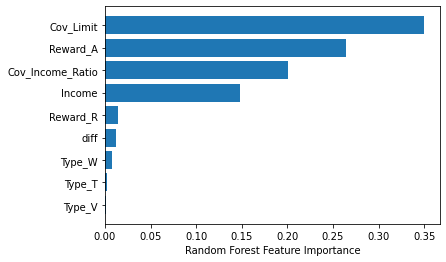

In [38]:
fit_rf = RandomForestClassifier(max_depth = 3, n_estimators = 500, class_weight = {0: 26.53, 1: 1}).fit(X, y)

importances = fit_rf.feature_importances_

sorted_idx = fit_rf.feature_importances_.argsort()

plt.barh(X.columns[sorted_idx], fit_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [39]:
train['pred_rf'] = fit_rf.predict_proba(X)[:,1]

train.head()

,Cust_ID,Date,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio,fraud_flag,weight,pred_dt,pred_lr,pred_nb,pred_rf
10408,PSX000308247,8/11/1999,V,306,150000,30,150000,25952,5.779901,0,26.529703,0.019161,0.015878,0.048946,0.020376
16756,PSX000435754,8/10/1990,T,310,350000,27,350000,47318,7.396762,0,26.529703,0.019161,0.037304,0.076877,0.020115
37292,PSX000854018,2/12/2011,T,105,100000,25,100000,38000,2.631579,0,26.529703,0.019161,0.010043,0.044484,0.019959
25897,PSX000622557,6/3/2008,V,342,100000,15,100000,48000,2.083333,0,26.529703,0.019161,0.008192,0.038028,0.019719
39843,PSX000906273,10/2/2002,T,263,100000,28,100000,20000,5.000000,0,26.529703,0.019161,0.011354,0.063894,0.020154


The next more advanced model we will build is a gradient boosting model. 

Text(0.5, 0, 'Gradient Boosting Feature Importance')

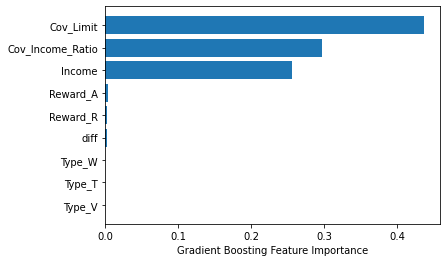

In [40]:
fit_xg = GradientBoostingClassifier(max_depth = 3, n_estimators = 100).fit(X, y)

importances = fit_xg.feature_importances_

sorted_idx = fit_xg.feature_importances_.argsort()

plt.barh(X.columns[sorted_idx], fit_xg.feature_importances_[sorted_idx])
plt.xlabel("Gradient Boosting Feature Importance")

In [41]:
train['pred_xg'] = fit_xg.predict_proba(X)[:,1]

train.head()

,Cust_ID,Date,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio,fraud_flag,weight,pred_dt,pred_lr,pred_nb,pred_rf,pred_xg
10408,PSX000308247,8/11/1999,V,306,150000,30,150000,25952,5.779901,0,26.529703,0.019161,0.015878,0.048946,0.020376,0.020144
16756,PSX000435754,8/10/1990,T,310,350000,27,350000,47318,7.396762,0,26.529703,0.019161,0.037304,0.076877,0.020115,0.036175
37292,PSX000854018,2/12/2011,T,105,100000,25,100000,38000,2.631579,0,26.529703,0.019161,0.010043,0.044484,0.019959,0.020144
25897,PSX000622557,6/3/2008,V,342,100000,15,100000,48000,2.083333,0,26.529703,0.019161,0.008192,0.038028,0.019719,0.022416
39843,PSX000906273,10/2/2002,T,263,100000,28,100000,20000,5.000000,0,26.529703,0.019161,0.011354,0.063894,0.020154,0.020144


### Model Evaluation

A common measure for comparing classification models is area under the ROC curve. It isn't the only metric, but worth taking a look at for our models.

First let's look at the decision tree.

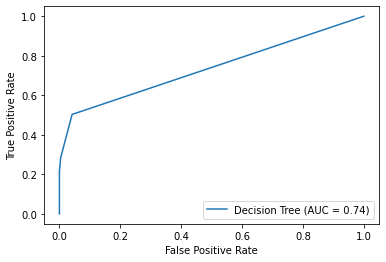

In [42]:
fpr, tpr, thresholds = metrics.roc_curve(y, train['pred_dt'])

roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Decision Tree')
display.plot()  
plt.show()

Let's see how we did for the logistic regression.

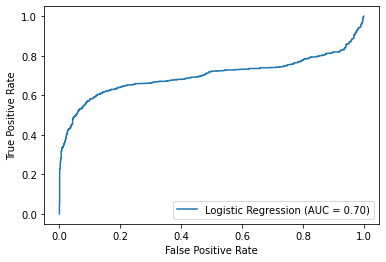

In [43]:
fpr, tpr, thresholds = metrics.roc_curve(y, train['pred_lr'])

roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot()  
plt.show()

Not as good as the decision tree. 

How about the naive Bayes model.

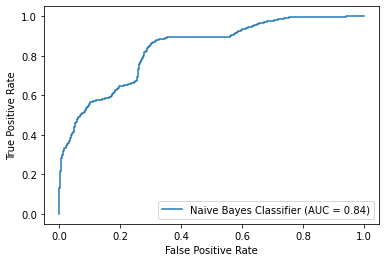

In [44]:
fpr, tpr, thresholds = metrics.roc_curve(y, train['pred_nb'])

roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Naive Bayes Classifier')
display.plot()  
plt.show()

Best one so far! 

Let's look at the machine learning models. First, the random forest.

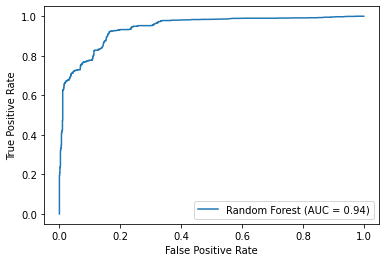

In [45]:
fpr, tpr, thresholds = metrics.roc_curve(y, train['pred_rf'])

roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest')
display.plot()  
plt.show()

Wow! That is really good. So good that we might be overfitting a little bit. Let's look at the gradient boosting model.

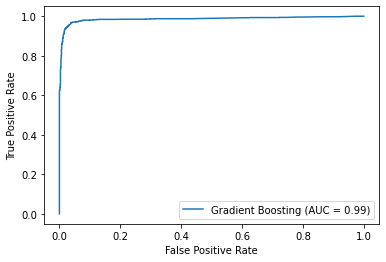

In [46]:
fpr, tpr, thresholds = metrics.roc_curve(y, train['pred_xg'])

roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Gradient Boosting')
display.plot()  
plt.show()

Again, very high. Why would this be the case?

Remember, we are predicting suspected fraud based on anomalies in our variables. Essentially, it seems that the machine learning models are repeating back to us, the same anomalies. 

Let's look at how the random forest model does in terms of the confusion matrix.

In [47]:
fpr, tpr, thresholds = metrics.roc_curve(y, train['pred_rf'])

i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'youden' : pd.Series(tpr - fpr, index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(-1*roc.youden).argsort()[:1]]

,fpr,tpr,1-fpr,youden,thresholds
297,0.165,0.923333,0.835,0.758333,0.033245


Let's see how good the model does on testing data.

In [48]:
X_test = test[['Type', 'Reward_R', 'Reward_A', 'diff', 'Cov_Limit', 'Income', 'Cov_Income_Ratio']]
y_test = test['fraud_flag']

X_test = pd.get_dummies(X_test)

test['pred_rf'] = fit_rf.predict_proba(X_test)[:,1]

test.head()

C:\Users\Aric\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Cust_ID,Date,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio,fraud_flag,pred_rf
0,PSX000100006,1/17/2006,T,265,50000,17,50000,61000,0.819672,0,0.033650
1,PSX000100013,7/11/2001,V,265,100000,29,100000,48000,2.083333,0,0.020398
2,PSX000100073,2/14/2004,V,450,100000,24,100000,35000,2.857143,0,0.019818
3,PSX000100081,7/26/2009,T,543,0,28,50000,69000,0.724638,0,0.033658
4,PSX000100122,9/8/1991,T,200,150000,16,150000,105000,1.428571,0,0.020033


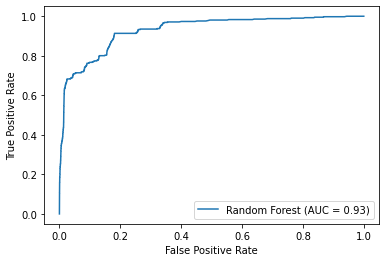

In [49]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, test['pred_rf'])

roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest')
display.plot()  
plt.show()

Still very good, but not surprisingly, a little worse on data it has never seen before.

Again, this does a good job of repeating back to us something that we have already suspected as fraud. What about new cases of fraud?

### NOT-Fraud Model

Let's flip the target around and see what we get for our NOT-fraud model.

In [50]:
train['not_fraud'] = np.where(train['fraud_flag'] == 1, 0, 1)

Text(0.5, 0, 'Random Forest Feature Importance - NOT Fraud')

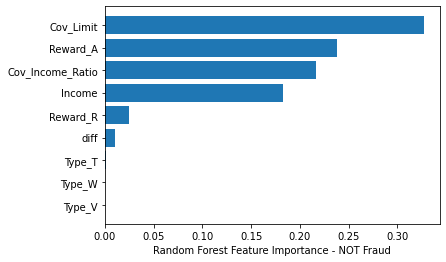

In [51]:
X = train[['Type', 'Reward_R', 'Reward_A', 'diff', 'Cov_Limit', 'Income', 'Cov_Income_Ratio']]
y = train['not_fraud']

X = pd.get_dummies(X)

fit_rf_NOT = RandomForestClassifier(max_depth = 3, n_estimators = 500, class_weight = {0: 26.53, 1: 1}).fit(X, y)

importances = fit_rf_NOT.feature_importances_

sorted_idx = fit_rf_NOT.feature_importances_.argsort()

plt.barh(X.columns[sorted_idx], fit_rf_NOT.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance - NOT Fraud")

In [52]:
test['pred_rf_NOT'] = fit_rf_NOT.predict_proba(X_test)[:,1]

test.head(n = 10)

C:\Users\Aric\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Cust_ID,Date,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio,fraud_flag,pred_rf,pred_rf_NOT
0,PSX000100006,1/17/2006,T,265,50000,17,50000,61000,0.819672,0,0.033650,0.037010
1,PSX000100013,7/11/2001,V,265,100000,29,100000,48000,2.083333,0,0.020398,0.232187
2,PSX000100073,2/14/2004,V,450,100000,24,100000,35000,2.857143,0,0.019818,0.232755
3,PSX000100081,7/26/2009,T,543,0,28,50000,69000,0.724638,0,0.033658,0.040917
4,PSX000100122,9/8/1991,T,200,150000,16,150000,105000,1.428571,0,0.020033,0.184409
5,PSX000100146,4/21/2009,T,275,100000,20,100000,38000,2.631579,0,0.020058,0.232256
6,PSX000100231,5/5/2008,V,405,400000,25,400000,79155,5.053376,0,0.019852,0.198297
7,PSX000100236,10/6/1970,T,469,250000,24,250000,54738,4.567211,0,0.020045,0.207045
8,PSX000100286,3/20/2003,V,337,150000,22,150000,95973,1.562940,0,0.019845,0.186764
9,PSX00010030,1/9/1980,T,377,350000,23,350000,37725,9.277667,0,0.020037,0.176151


Notice how the predictions are not just the exact opposite in probability! We want to find observations that are low in both models.

In [53]:
test['pred_avg'] = 0.5*(test['pred_rf'] + test['pred_rf_NOT'])

test.head(n = 10)

C:\Users\Aric\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Cust_ID,Date,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio,fraud_flag,pred_rf,pred_rf_NOT,pred_avg
0,PSX000100006,1/17/2006,T,265,50000,17,50000,61000,0.819672,0,0.033650,0.037010,0.035330
1,PSX000100013,7/11/2001,V,265,100000,29,100000,48000,2.083333,0,0.020398,0.232187,0.126292
2,PSX000100073,2/14/2004,V,450,100000,24,100000,35000,2.857143,0,0.019818,0.232755,0.126287
3,PSX000100081,7/26/2009,T,543,0,28,50000,69000,0.724638,0,0.033658,0.040917,0.037287
4,PSX000100122,9/8/1991,T,200,150000,16,150000,105000,1.428571,0,0.020033,0.184409,0.102221
5,PSX000100146,4/21/2009,T,275,100000,20,100000,38000,2.631579,0,0.020058,0.232256,0.126157
6,PSX000100231,5/5/2008,V,405,400000,25,400000,79155,5.053376,0,0.019852,0.198297,0.109074
7,PSX000100236,10/6/1970,T,469,250000,24,250000,54738,4.567211,0,0.020045,0.207045,0.113545
8,PSX000100286,3/20/2003,V,337,150000,22,150000,95973,1.562940,0,0.019845,0.186764,0.103304
9,PSX00010030,1/9/1980,T,377,350000,23,350000,37725,9.277667,0,0.020037,0.176151,0.098094


In [54]:
test.sort_values(by = ['pred_avg'])

,Cust_ID,Date,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio,fraud_flag,pred_rf,pred_rf_NOT,pred_avg
13988,PSX000379732,5/5/2001,T,185,700000,24,700000,63122,11.089636,0,0.031819,0.017524,0.024671
8527,PSX000269834,8/9/1992,T,264,700000,26,700000,62965,11.117287,0,0.031823,0.017524,0.024674
15587,PSX000412591,9/21/2006,T,161,700000,26,700000,62806,11.145432,0,0.031860,0.017524,0.024692
6166,PSX000223626,12/15/2001,V,419,700000,21,700000,63478,11.027443,0,0.031479,0.017962,0.024721
19657,PSX00049404,1/26/2000,T,198,700000,23,700000,62783,11.149515,0,0.031793,0.017656,0.024724
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30285,PSX000711530,4/6/2000,V,181,1850000,20,1850000,134778,13.726276,1,0.945824,0.002630,0.474227
36716,PSX000842653,3/6/1987,T,410,2200000,29,2200000,124914,17.612117,1,0.947999,0.002722,0.475361
10014,PSX00030024,12/4/1994,T,115,1600000,21,1600000,131060,12.208149,1,0.948423,0.002627,0.475525
18639,PSX000474725,2/13/2012,V,219,2700000,23,2700000,143783,18.778298,1,0.961119,0.002566,0.481842


Some of those observations are not really high on either of the models!

## Implementation and Deployment

Let's try to interpret our fraud model that was a random forest. LIME in Python is rather easy to build. 

Let's rebuild our random forest fraud model.

In [73]:
X = train[['Type', 'Reward_R', 'Reward_A', 'diff', 'Cov_Limit', 'Income', 'Cov_Income_Ratio']]
y = train['fraud_flag']

X = pd.get_dummies(X)

fit_rf = RandomForestClassifier(max_depth = 3, n_estimators = 500, class_weight = {0: 26.53, 1: 1}).fit(X, y)

Here we are building a simple model to extract the predicted probabilities from our random forest to put into the LIME explainer functionality.

In [74]:
pred_rf = lambda x: fit_rf.predict_proba(x).astype(float)

In [78]:
explainer = lime.lime_tabular.LimeTabularExplainer(X.values, feature_names = X.columns, 
                                                   class_names=['No Fraud','Fraud'], kernel_width=5)

explanations = X_test.loc[[18639]].values[0]
exp = explainer.explain_instance(explanations, pred_rf, num_features=10)

exp.show_in_notebook(show_all=False)

In [81]:
explanations = X_test.loc[[0]].values[0]
exp = explainer.explain_instance(explanations, pred_rf, num_features=10)

exp.show_in_notebook(show_all=False)